In [1]:
#SELECTION DEFINITION

THE_BIG_SELECTION = (
    "((Dst_M - D0_M) > 143) & ((Dst_M - D0_M) < 148) & "
    "(K_IPCHI2_OWNPV > 3) & (pi_IPCHI2_OWNPV > 3) & "
    "(K_TRACK_CHI2NDOF < 1.7) & (pi_TRACK_CHI2NDOF < 1.7) & "
    "(K_PT > 250) & (pi_PT > 250) & "
    "(K_hasRich == 1) & (pi_hasRich == 1) & "
    "(mp_TRACK_CHI2NDOF < 2) & "
    "(mm_TRACK_CHI2NDOF < 2) & "
    "(mp_isMuon == 1) & (mm_isMuon == 1) & "
    "(mp_PIDmu > 0) & (mm_PIDmu > 0) & "
    "(mp_PT > 700) & (mm_PT > 700) & "
    "(mp_IPCHI2_OWNPV > 2) & (mm_IPCHI2_OWNPV > 2) & "
    "(Jpsi_M < 3140) & (Jpsi_M > 3040) & "
    "(pi_soft_PT > 250) & "
    "(Bc_ENDVERTEX_CHI2 < 4.2) & "
    "(Bc_IPCHI2_OWNPV < 10) & "
    "(Bc_DIRA_OWNPV > 0.99)"
)


In [2]:
#IMPORTING LIBRARIES
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
import zfit

from xgboost import XGBClassifier, callback, plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import pickle
import optuna
import joblib
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

/Users/khrystina/new_env/lib/python3.11/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/Users/khrystina/new_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#DATA DOWNLOADING
files_simu = [
    './simulation/2011_MagDown.root', 
    './simulation/2015_MagDown.root',
    './simulation/2015_MagUp.root',
    './simulation/2016_MagDown.root',
    './simulation/2016_MagUp.root',
    './simulation/2017_MagDown.root',
    './simulation/2017_MagUp.root',
    './simulation/2018_MagDown.root',
    './simulation/2018_MagUp.root'
]

files_real_data = [
    './real_data/2011_MagDown.root', 
    './real_data/2011_MagUp.root',
    './real_data/2012_MagDown.root', 
    './real_data/2012_MagUp.root',
    './real_data/2015_MagDown.root', 
    './real_data/2015_MagUp.root',
    './real_data/2016_MagDown.root', 
    './real_data/2016_MagUp.root',
    './real_data/2017_MagDown.root', 
    './real_data/2017_MagUp.root',
    './real_data/2018_MagDown.root', 
    './real_data/2018_MagUp.root'
]
simu_data = uproot.concatenate(files_simu, cut = f"{THE_BIG_SELECTION} & (Bc_BKGCAT == 0)", library='pd')
real_data = uproot.concatenate(files_real_data, cut = f"{THE_BIG_SELECTION} & ((Bc_FullDTF_M < 6250.) | (Bc_FullDTF_M > 6300.))", library='pd')
real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1612/2903014781.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1612/2903014781.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']


In [4]:
#DEFINING TRAINING FEATURES

feature_columns = [

    'mp_PT',
    'mm_PT',
    'Bc_ENDVERTEX_CHI2',
    'Bc_IPCHI2_OWNPV',

    'Bc_FD_OWNPV',
    'Jpsi_FD_ORIVX',
    'D0_FD_ORIVX'
    ]
#PREPARING DATASET
# Separate features and labels
X_simu = simu_data[feature_columns]
y_simu = np.ones(len(simu_data))  # Label: 1 for simulation data

X_real = real_data[feature_columns]
y_real = np.zeros(len(real_data))  # Label: 0 for real data

# Combine features and labels
X_all = pd.concat([X_simu, X_real], ignore_index=True)
y_all = np.concatenate([y_simu, y_real]) 

print(f"SIMULATION set size: {X_simu.shape}")
print(f"REAL DATA set size: {X_real.shape}")


SIMULATION set size: (28209, 7)
REAL DATA set size: (2594, 7)


In [8]:
#ACCURACY

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=92)

# Predict on the test set
y_pred = classif_list[1].predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.49      0.60       558
         1.0       0.95      0.99      0.97      5603

    accuracy                           0.94      6161
   macro avg       0.88      0.74      0.79      6161
weighted avg       0.94      0.94      0.94      6161



In [7]:
#TRAINING MODEL WITH K-FOLD AND EARLY STOPPING
from sklearn.preprocessing import LabelEncoder
n_folds = 5
fold_accuracies = []

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=11)

# Load Optuna-saved model parameters
with open("best_optuna_model.pkl", "rb") as file:
    best_model_params = pickle.load(file)
try:
    print(type(best_model_params))  # Debugging step
    print(best_model_params) 
    if isinstance(best_model_params, XGBClassifier):
        best_model_params = best_model_params.get_params()  # Extract parameters from model
    elif not isinstance(best_model_params, dict):
        raise TypeError(f"Unexpected type for best_model_params: {type(best_model_params)}")

    elif not isinstance(best_model_params, dict):
        raise TypeError("Unexpected type for best_model_params:", type(best_model_params))


except ImportError as e:
    print("ImportError occurred:", e)

# Ensure parameters are valid for XGBClassifier
if hasattr(best_model_params, 'get_params'):
    best_model_params = best_model_params.get_params()


best_model_params.update({
    'random_state': 51, 
    'eval_metric': 'logloss' ,
    'early_stopping_rounds': 20 
})

classif_list = []
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_all, y_all)):
    print(f"Processing Fold {fold + 1}/{n_folds}...")
    # Initialize the model with the best parameters
    model_es = XGBClassifier(**best_model_params)
    # Split the data using iloc for pandas DataFrame compatibility
    X_train, X_val = X_all.iloc[train_index], X_all.iloc[val_index]
    y_train, y_val = y_all[train_index], y_all[val_index]
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    

    # Fit the model with early stopping
    model_es.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    classif_list.append(model_es)
    # Evaluate the model on the validation set
    y_pred = model_es.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

mean_accuracy = np.mean(fold_accuracies)
print(f"\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}")

model_es.save_model("best_kfold_early_stopping_model.json")


<class 'xgboost.sklearn.XGBClassifier'>
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.057345347578566394, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=233, n_jobs=None,
              num_parallel_tree=None, random_state=52, ...)
Processing Fold 1/5...
Fold 1 Accuracy: 0.9456
Processing Fold 2/5...
Fold 2 Accuracy: 0.9403
Processing Fold 3/5...
Fold 3 Accuracy: 0.9408
Processing Fold 4/5...
Fold 4 Ac

In [9]:

real_data_predictions = classif_list[1].predict_proba(X_real)[:, 1]
real_data_filtered = real_data[real_data_predictions > 0.8]


FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.basic.Exponential'>  params=[lambda, lambda]] data=[<zfit.Data: Data obs=('Bc_M',) shape=(177, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 6.5e-07 │          1149.94 |  10029.21 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
N_bkg              176.997       False
lambda         -0.00194841       False
Fitted lambda: -0.001948
Fitted background yield: 177.00
SIGNAL: [24.33186415]
TRUE_BCKG: [82.20782893]
SIGNIFICANCE: [2.1276663]
Len of background: 288.00


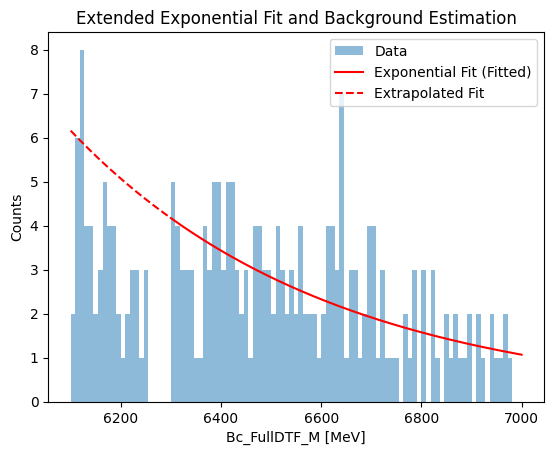

In [11]:
#SUPER CORRECT
mass_values = real_data_filtered['Bc_FullDTF_M'].values
mass_values_fit = mass_values[mass_values > 6300]

mass_space_fit = zfit.Space("Bc_M", limits=(6300, 7000))
data_fit = zfit.Data.from_numpy(obs=mass_space_fit, array=mass_values_fit)

lambda_param = zfit.Parameter("lambda", -0.002, -0.005, -0.0001) 
N_bkg = zfit.Parameter("N_bkg", len(mass_values_fit), 0, 1e6)  

exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_space_fit)
exp_pdf_extended = exp_pdf.create_extended(N_bkg)

nll = zfit.loss.ExtendedUnbinnedNLL(model=exp_pdf_extended, data=data_fit)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
print(result)

lambda_fit = lambda_param.numpy()
N_bkg_fit = N_bkg.numpy()
print(f"Fitted lambda: {lambda_fit:.6f}")
print(f"Fitted background yield: {N_bkg_fit:.2f}")

nbins = 100
bins = np.linspace(6100, 7000, nbins)
bin_width = (7000 - 6100) / nbins

hist, bin_edges = np.histogram(mass_values, bins=bins)
plt.hist(mass_values, bins=bins, alpha=0.5, label="Data")

x_fit = np.linspace(6100, 7000, 1000)
y_fit = exp_pdf_extended.pdf(x_fit, norm=mass_space_fit).numpy() * N_bkg_fit * bin_width

mask_fit = x_fit >= 6300
mask_extrap = x_fit < 6300

plt.plot(x_fit[mask_fit], y_fit[mask_fit], label="Exponential Fit (Fitted)", color="red")
plt.plot(x_fit[mask_extrap], y_fit[mask_extrap], '--', color="red", label="Extrapolated Fit")

SIGNAL = exp_pdf_extended.ext_integrate(limits=(6250, 6300)).numpy()
TRUE_BCKG = exp_pdf_extended.ext_integrate(limits=(6220, 6400)).numpy()

S = 13  
significance = S / np.sqrt(S + SIGNAL)

print(f"SIGNAL: {SIGNAL}")
print(f"TRUE_BCKG: {TRUE_BCKG}")
print(f"SIGNIFICANCE: {significance}")
print(f"Len of background: {len(mass_values_fit):.2f}")

plt.xlabel("Bc_FullDTF_M [MeV]")
plt.ylabel("Counts")
plt.legend()
plt.title(f"Extended Exponential Fit and Background Estimation")
plt.show()


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1037/2721209469.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SIGNAL = float(exp_pdf_extended.ext_integrate(limits=(6250, 6300)).numpy())


Best threshold: 0.990 with significance: 3.489


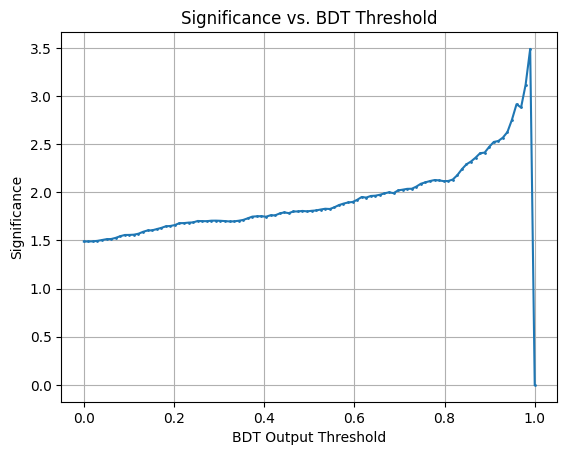

In [81]:
#SIGNIFICANCE _ BDT PLOT
bdt_thresholds = np.linspace(0.0, 1.0, 100)  
significance_values = []

max_significance = 0.0
best_threshold = None

for threshold in bdt_thresholds:
    real_data_filtered = real_data[real_data_predictions > threshold]
    mass_values = real_data_filtered['Bc_FullDTF_M'].values
    mass_values_fit = mass_values[mass_values > 6300]

    if len(mass_values_fit) == 0:
        significance_values.append(0.0)
        continue

    mass_space_fit = zfit.Space("Bc_M", limits=(6300, 7000))
    data_fit = zfit.Data.from_numpy(obs=mass_space_fit, array=mass_values_fit)

    lambda_param = zfit.Parameter("lambda", -0.002, -0.005, -0.0001) 
    N_bkg = zfit.Parameter("N_bkg", max(len(mass_values_fit), 1), 0, 1e6)  

    exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_space_fit)
    exp_pdf_extended = exp_pdf.create_extended(N_bkg)
    nll = zfit.loss.ExtendedUnbinnedNLL(model=exp_pdf_extended, data=data_fit)
    minimizer = zfit.minimize.Minuit()

    try:
        result = minimizer.minimize(nll)
        SIGNAL = float(exp_pdf_extended.ext_integrate(limits=(6250, 6300)).numpy())
    except (zfit.minimizers.strategy.FailMinimizeNaN, RuntimeError):
        SIGNAL = 0.0  

    S = 13 
    significance = S / np.sqrt(S + SIGNAL) if SIGNAL > 0 else 0.0
    significance_values.append(significance)

    if significance > max_significance:
        max_significance = significance
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.3f} with significance: {max_significance:.3f}")

plt.plot(bdt_thresholds, significance_values, marker='o', linestyle='-', markersize = 1)
plt.xlabel("BDT Output Threshold")
plt.ylabel("Significance")
plt.title("Significance vs. BDT Threshold")
plt.grid()
plt.show()


FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.basic.Exponential'>  params=[lambda, lambda]] data=[<zfit.Data: Data obs=('Bc_M',) shape=(95, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 5.7e-07 │           615.60 |  10090.07 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
N_bkg              94.9999       False
lambda         -0.00233802       False
Fitted lambda: -0.002338
Fitted background yield: 95.00
SIGNAL: [14.62788891]
SIGNIFICANCE: [2.47325845]
Len of background: 151.00


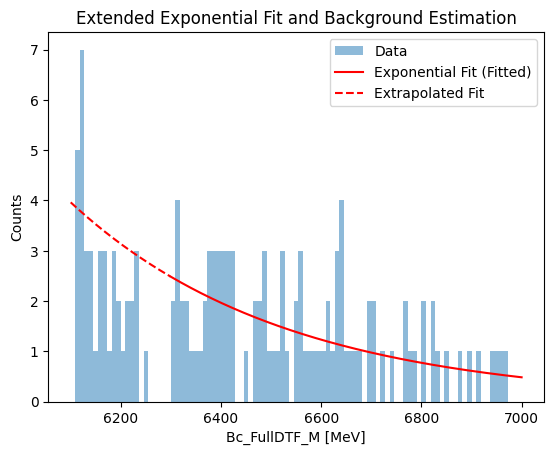

In [94]:
real_data_predictions = classif_list[1].predict_proba(X_real)[:, 1]
real_data_filtered = real_data[real_data_predictions > 0.9]

#SUPER CORRECT


mass_values = real_data_filtered['Bc_FullDTF_M'].values
mass_values_fit = mass_values[mass_values > 6300]

mass_space_fit = zfit.Space("Bc_M", limits=(6300, 7000))
data_fit = zfit.Data.from_numpy(obs=mass_space_fit, array=mass_values_fit)

lambda_param = zfit.Parameter("lambda", -0.002, -0.005, -0.0001) 
N_bkg = zfit.Parameter("N_bkg", len(mass_values_fit), 0, 1e6)  

exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_space_fit)
exp_pdf_extended = exp_pdf.create_extended(N_bkg)

nll = zfit.loss.ExtendedUnbinnedNLL(model=exp_pdf_extended, data=data_fit)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
print(result)

lambda_fit = lambda_param.numpy()
N_bkg_fit = N_bkg.numpy()
print(f"Fitted lambda: {lambda_fit:.6f}")
print(f"Fitted background yield: {N_bkg_fit:.2f}")

nbins = 100
bins = np.linspace(6100, 7000, nbins)
bin_width = (7000 - 6100) / nbins

hist, bin_edges = np.histogram(mass_values, bins=bins)
plt.hist(mass_values, bins=bins, alpha=0.5, label="Data")

x_fit = np.linspace(6100, 7000, 1000)
y_fit = exp_pdf_extended.pdf(x_fit, norm=mass_space_fit).numpy() * N_bkg_fit * bin_width

mask_fit = x_fit >= 6300
mask_extrap = x_fit < 6300

plt.plot(x_fit[mask_fit], y_fit[mask_fit], label="Exponential Fit (Fitted)", color="red")
plt.plot(x_fit[mask_extrap], y_fit[mask_extrap], '--', color="red", label="Extrapolated Fit")

SIGNAL = exp_pdf_extended.ext_integrate(limits=(6250, 6300)).numpy()

S = 13  
significance = S / np.sqrt(S + SIGNAL)

print(f"SIGNAL: {SIGNAL}")
print(f"SIGNIFICANCE: {significance}")
print(f"Len of background: {len(mass_values_fit):.2f}")

plt.xlabel("Bc_FullDTF_M [MeV]")
plt.ylabel("Counts")
plt.legend()
plt.title(f"Extended Exponential Fit and Background Estimation")
plt.show()


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_1037/4093390628.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SIGNAL = float(exp_pdf_extended.ext_integrate(limits=(6250, 6300)).numpy())


Best threshold: 0.960 with significance: 2.389
BDT Efficiency at best threshold: 0.750


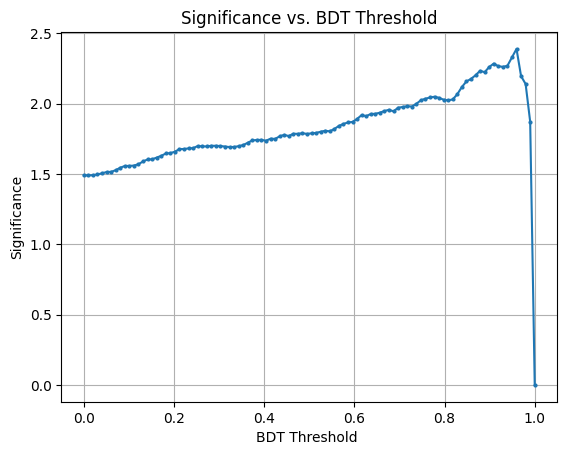

In [91]:
bdt_thresholds = np.linspace(0.0, 1.0, 100)  
significance_values = []
bdt_efficiencies = []  

max_significance = 0.0
best_threshold = None
best_efficiency = None

train_bdt_scores_simu = classif_list[1].predict_proba(X_simu)[:, 1]  

for threshold in bdt_thresholds:

    real_data_filtered = real_data[real_data_predictions > threshold]
    mass_values = real_data_filtered["Bc_FullDTF_M"].values
    mass_values_fit = mass_values[mass_values > 6300]

    signal_retained = np.sum(train_bdt_scores_simu > threshold)  
    bdt_efficiency = signal_retained / len(X_simu) if len(X_simu) > 0 else 0  
    bdt_efficiencies.append(bdt_efficiency)

    if len(mass_values_fit) == 0:
        significance_values.append(0.0)
        continue

    mass_space_fit = zfit.Space("Bc_M", limits=(6300, 7000))
    data_fit = zfit.Data.from_numpy(obs=mass_space_fit, array=mass_values_fit)

    lambda_param = zfit.Parameter("lambda", -0.002, -0.005, -0.0001) 
    N_bkg = zfit.Parameter("N_bkg", max(len(mass_values_fit), 1), 0, 1e6)  

    exp_pdf = zfit.pdf.Exponential(lambda_param, obs=mass_space_fit)
    exp_pdf_extended = exp_pdf.create_extended(N_bkg)
    nll = zfit.loss.ExtendedUnbinnedNLL(model=exp_pdf_extended, data=data_fit)
    minimizer = zfit.minimize.Minuit()

    try:
        result = minimizer.minimize(nll)
        SIGNAL = float(exp_pdf_extended.ext_integrate(limits=(6250, 6300)).numpy())
    except (zfit.minimizers.strategy.FailMinimizeNaN, RuntimeError):
        SIGNAL = 0.0  

    S = 13 * bdt_efficiency  
    significance = S / np.sqrt(S + SIGNAL) if SIGNAL > 0 else 0.0
    significance_values.append(significance)

    if significance > max_significance:
        max_significance = significance
        best_threshold = threshold
        best_efficiency = bdt_efficiency  


print(f"Best threshold: {best_threshold:.3f} with significance: {max_significance:.3f}")
print(f"BDT Efficiency at best threshold: {best_efficiency:.3f}")

plt.plot(bdt_thresholds, significance_values, marker='o', linestyle='-', markersize=2)
plt.xlabel("BDT Threshold ")
plt.ylabel("Significance")
plt.title("Significance vs. BDT Threshold")
plt.grid()
plt.show()


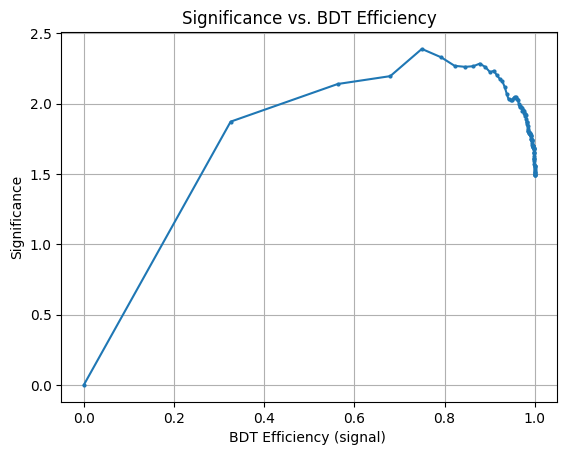

In [92]:
plt.plot(bdt_efficiencies, significance_values, marker='o', linestyle='-', markersize=2)
plt.xlabel("BDT Efficiency (signal) ")
plt.ylabel("Significance")
plt.title("Significance vs. BDT Efficiency")
plt.grid()
plt.show()